In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

metadata_df = pd.read_parquet('/content/drive/MyDrive/google-photos/metadata.parquet')
metadata_df.head(1)

,title,folder,imageViews,photoTakenTime,latitude,longitude,url,people,googlePhotosOrigin
0,DSCF6027.JPG,Cat Ba - Day 4,24,1750821602,NaN,NaN,AF1QipPzfNbGtPI571WptxyvtwZupAylatxRLFKwXNsZ,[],webUpload


In [3]:
import pandas as pd

images_df = pd.read_parquet('/content/drive/MyDrive/google-photos/images.parquet')
images_df.head(1)

,filename,folder,size_mb
0,PXL_20251103_231227674.jpg,Stargazing in Times City,2.32


In [4]:
metadata_df.shape[0]

20878

In [5]:
images_df.shape[0]

37325

In [6]:
import ast

images_df['_filename_lower'] = images_df['filename'].str.lower()
metadata_df['_title_lower'] = metadata_df['title'].str.lower()

df = pd.merge(images_df, metadata_df,
                     left_on=['folder', '_filename_lower'],
                     right_on=['folder', '_title_lower'],
                     how='inner')

df = df.drop(columns=['_filename_lower', '_title_lower'])
df['people'] = df['people'].apply(ast.literal_eval)

df.head(1)

,filename,folder,size_mb,title,imageViews,photoTakenTime,latitude,longitude,url,people,googlePhotosOrigin
0,20230528_075050.jpg,On the run,2.51,20230528_075050.jpg,0,1685231450,1.290493,103.867788,AF1QipNgUKChXM5Fqk8L-847-TmSBNTWH57Md6dY1HOr,[],mobileUpload


In [7]:
df.shape[0]

20385

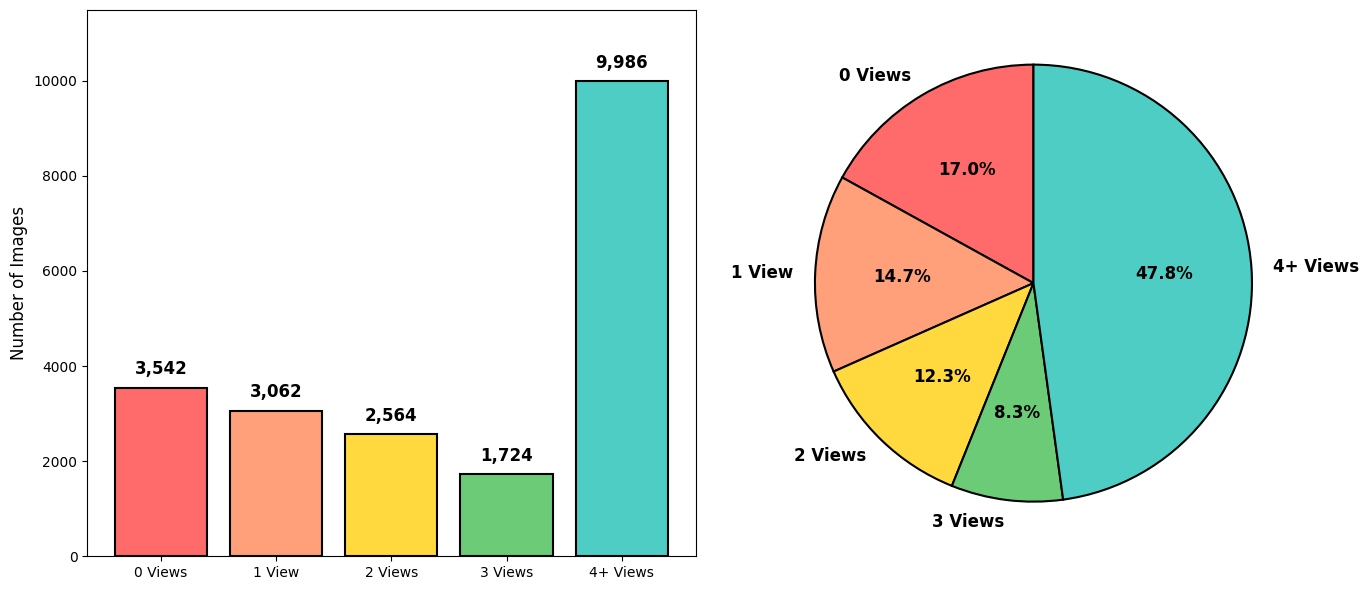


IMAGE VIEW SUMMARY
Total images: 20,878
Images with 0 views: 3,542 (17.0%)
Images with 1 view: 3,062 (14.7%)
Images with 2 views: 2,564 (12.3%)
Images with 3 views: 1,724 (8.3%)
Images with 4+ views: 9,986 (47.8%)


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by filename and sum views
image_counts = metadata_df.groupby('url')['imageViews'].sum()

# Count images by view brackets
zero_views = (image_counts == 0).sum()
one_view = (image_counts == 1).sum()
two_views = (image_counts == 2).sum()
three_views = (image_counts == 3).sum()
more_views = (image_counts > 3).sum()

# Create bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart showing view brackets
categories = ['0 Views', '1 View', '2 Views', '3 Views', '4+ Views']
counts = [zero_views, one_view, two_views, three_views, more_views]
colors = ['#FF6B6B', '#FFA07A', '#FFD93D', '#6BCB77', '#4ECDC4']

ax1.bar(categories, counts, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_ylim(0, max(counts) * 1.15)  # Add 15% padding at top

# Add count labels on bars
for i, (cat, count) in enumerate(zip(categories, counts)):
    ax1.text(i, count + max(counts)*0.02, f'{count:,}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Pie chart for percentage view
ax2.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%',
        startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'},
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})

plt.tight_layout()
plt.show()

# Print summary statistics
total_images = len(image_counts)
print(f"\n{'='*50}")
print(f"IMAGE VIEW SUMMARY")
print(f"{'='*50}")
print(f"Total images: {total_images:,}")
print(f"Images with 0 views: {zero_views:,} ({zero_views/total_images*100:.1f}%)")
print(f"Images with 1 view: {one_view:,} ({one_view/total_images*100:.1f}%)")
print(f"Images with 2 views: {two_views:,} ({two_views/total_images*100:.1f}%)")
print(f"Images with 3 views: {three_views:,} ({three_views/total_images*100:.1f}%)")
print(f"Images with 4+ views: {more_views:,} ({more_views/total_images*100:.1f}%)")
print(f"{'='*50}")

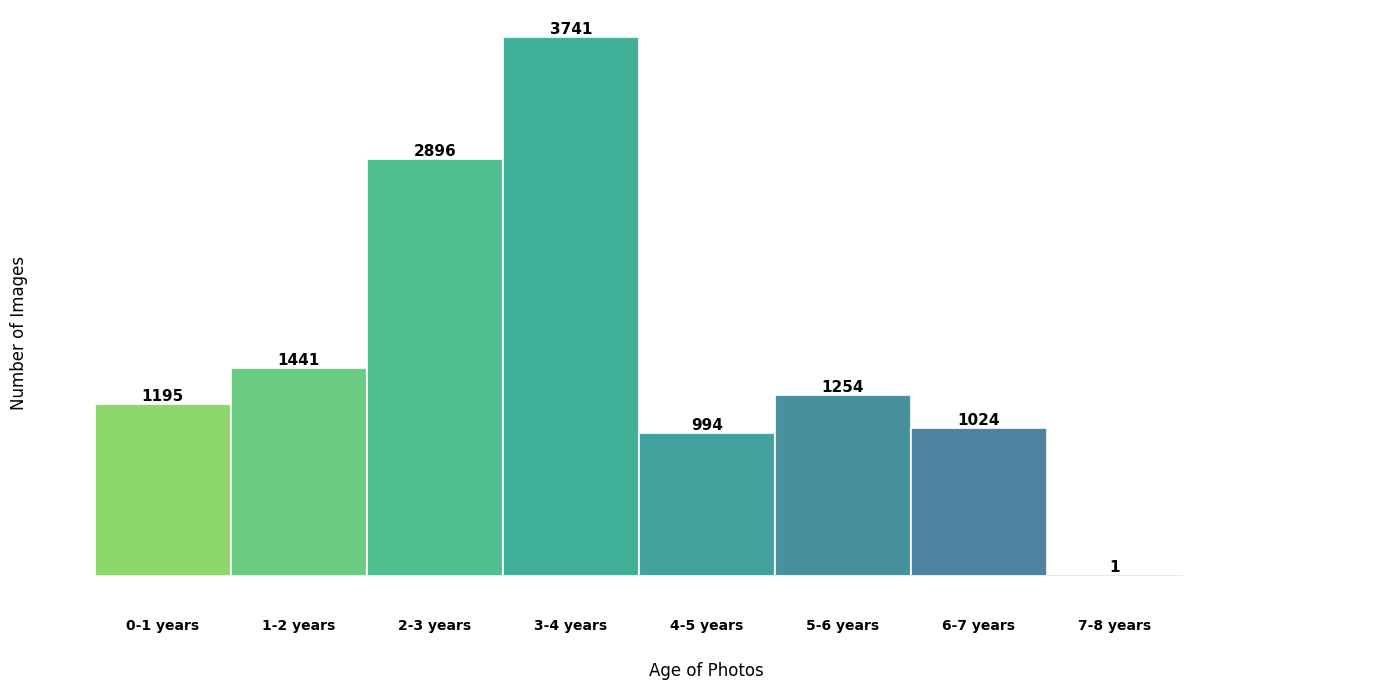


📊 Photo Distribution by Year:
0-1 years       | 1195 photos (  9.5%)
1-2 years       | 1441 photos ( 11.5%)
2-3 years       | 2896 photos ( 23.1%)
3-4 years       | 3741 photos ( 29.8%)
4-5 years       |  994 photos (  7.9%)
5-6 years       | 1254 photos ( 10.0%)
6-7 years       | 1024 photos (  8.2%)
7-8 years       |    1 photos (  0.0%)


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Convert Unix epoch to datetime
df['photoTakenTime'] = pd.to_datetime(df['photoTakenTime'], unit='s')

# Calculate age in years
today = pd.Timestamp.now()
df['age_years'] = (today - df['photoTakenTime']).dt.days / 365.25

# Remove duplicate filenames to count unique photos
df_unique = df.drop_duplicates(subset='filename')

# Create bins for years (0-1, 1-2, 2-3, etc.)
max_age = int(np.ceil(df_unique['age_years'].max()))
bins = range(0, max_age + 2)

# Create the figure with white background
fig, ax = plt.subplots(figsize=(14, 7), facecolor='white')
ax.set_facecolor('white')

# Create histogram
counts, edges, patches = ax.hist(df_unique['age_years'], bins=bins,
                                  edgecolor='white', linewidth=1.5, alpha=0.85)

# Color gradient from newest (vibrant) to oldest (muted)
colors = plt.cm.viridis(np.linspace(0.8, 0.2, len(patches)))
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

# Remove grid, axes, labels
ax.grid(False)
ax.set_xlabel('Age of Photos', fontsize=12)
ax.set_ylabel('Number of Images', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])

# Add statistics text box
total_photos = len(df_unique)
oldest_age = df_unique['age_years'].max()
newest_age = df_unique['age_years'].min()
avg_age = df_unique['age_years'].mean()

# Adjust y-axis to make room for labels below
ax.set_ylim(bottom=-max(counts)*0.15)

# Add clear labels on each bar
for i, (count, edge) in enumerate(zip(counts, edges[:-1])):
    if count > 0:
        # Add count on top of bar
        ax.text(edge + 0.5, count, f'{int(count)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

        # Add year range label below the bar
        year_label = f'{int(edge)}-{int(edge+1)} years'
        ax.text(edge + 0.5, -max(counts)*0.08, year_label,
                ha='center', va='top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Optional: Print detailed breakdown
print("\n📊 Photo Distribution by Year:")
print("="*50)
for i in range(len(counts)):
    if counts[i] > 0:
        year_range = f"{int(edges[i])}-{int(edges[i+1])} years"
        percentage = (counts[i] / total_photos) * 100
        print(f"{year_range:15} | {int(counts[i]):4} photos ({percentage:5.1f}%)")
print("="*50)

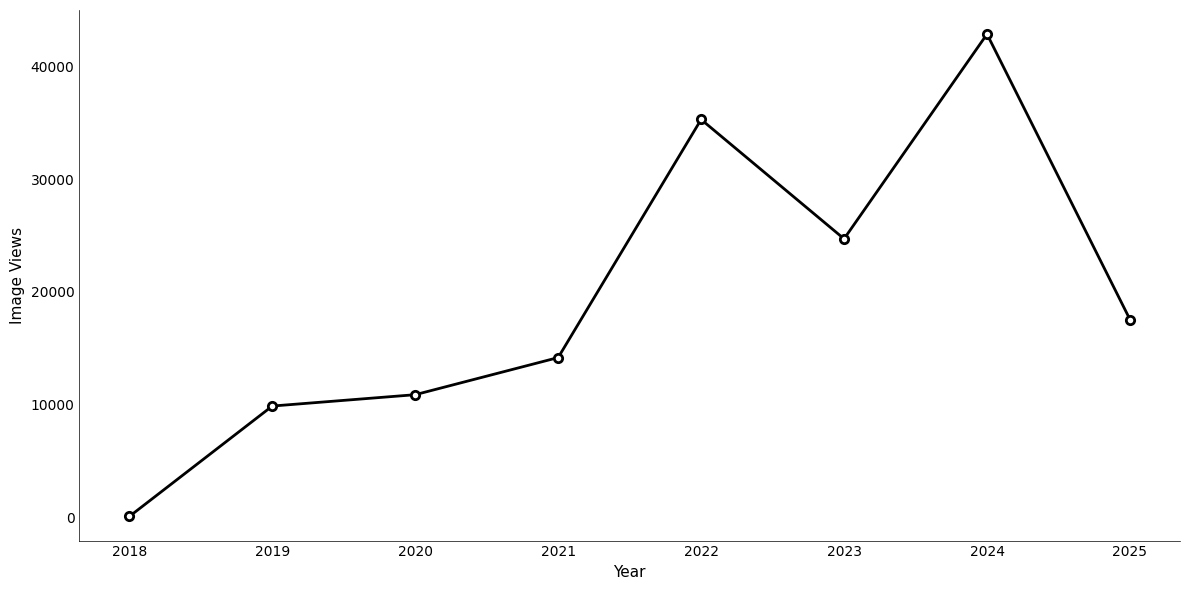

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert Unix epoch to datetime and extract the year
df['year'] = pd.to_datetime(df['photoTakenTime'], unit='s').dt.year

# Group by year and sum image views
yearly_views = df.groupby('year')['imageViews'].sum().reset_index()

# Create minimalistic plot
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
ax.set_facecolor('white')

# Plot with clean lines
ax.plot(yearly_views['year'], yearly_views['imageViews'],
        color='black', linewidth=2, marker='o', markersize=6,
        markerfacecolor='white', markeredgewidth=2, markeredgecolor='black')

# Minimal styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_color('black')

ax.set_xlabel('Year', fontsize=11, color='black')
ax.set_ylabel('Image Views', fontsize=11, color='black')

ax.tick_params(colors='black', which='both', length=0)
ax.grid(False)

plt.tight_layout()
plt.show()

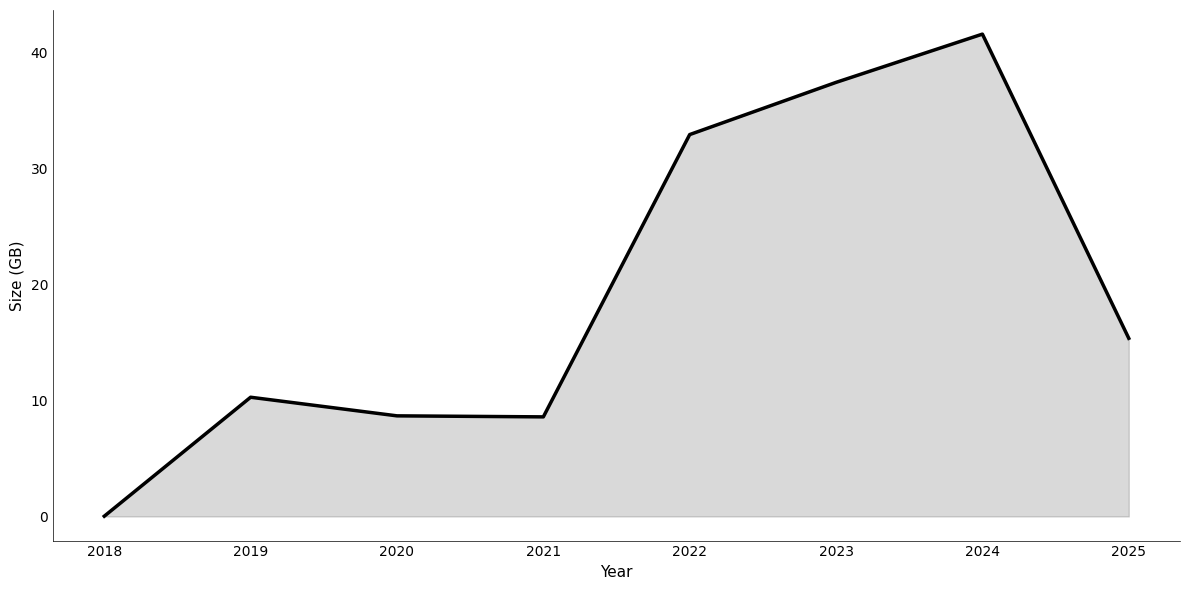

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert size to GB
df['size_gb'] = df['size_mb'] / 1024

# Group by year and sum size
yearly_size = df.groupby('year')['size_gb'].sum().reset_index()

# Create minimalistic plot with different style
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
ax.set_facecolor('white')

# Plot with filled area style
ax.fill_between(yearly_size['year'], yearly_size['size_gb'],
                color='black', alpha=0.15)
ax.plot(yearly_size['year'], yearly_size['size_gb'],
        color='black', linewidth=2.5)

# Minimal styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_color('black')

ax.set_xlabel('Year', fontsize=11, color='black')
ax.set_ylabel('Size (GB)', fontsize=11, color='black')

ax.tick_params(colors='black', which='both', length=0)
ax.grid(False)

plt.tight_layout()
plt.show()

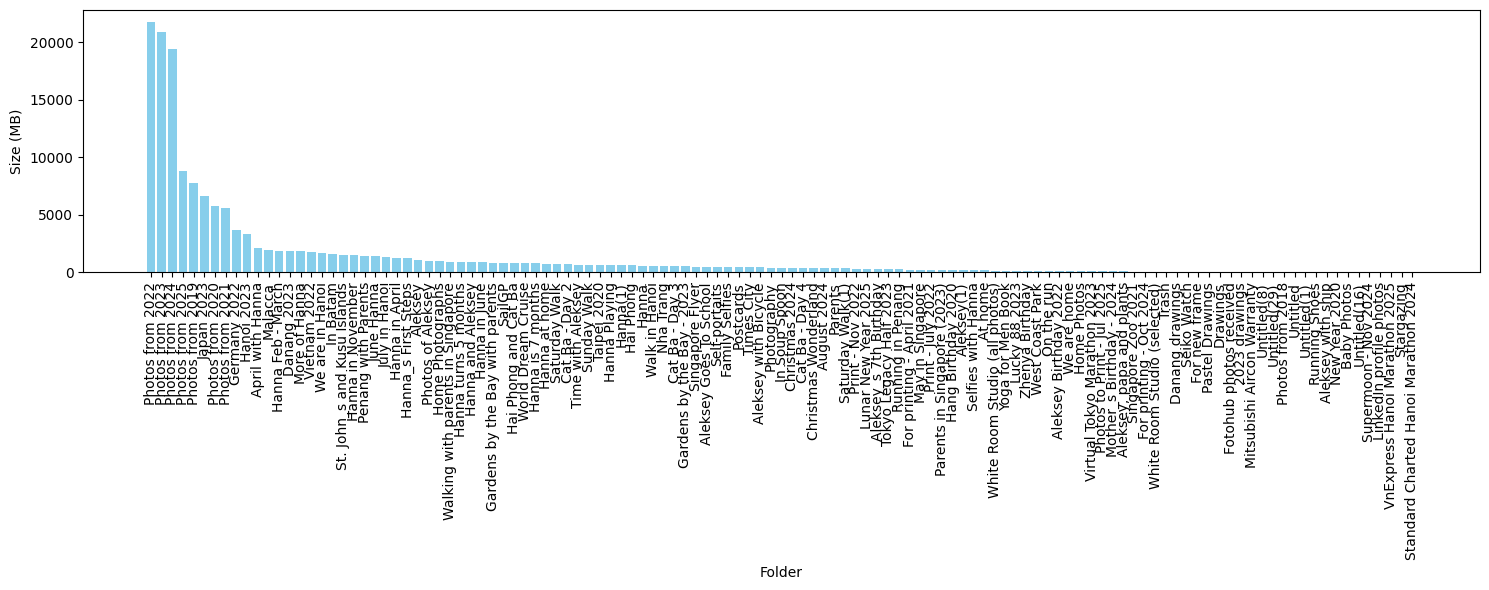

In [12]:
df_sum = df.groupby('folder', as_index=False)['size_mb'].sum()
df_sum = df_sum.sort_values('size_mb', ascending=False)
plt.figure(figsize=(15, 6))
plt.bar(df_sum['folder'], df_sum['size_mb'], color='skyblue')
plt.xlabel('Folder')
plt.ylabel('Size (MB)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

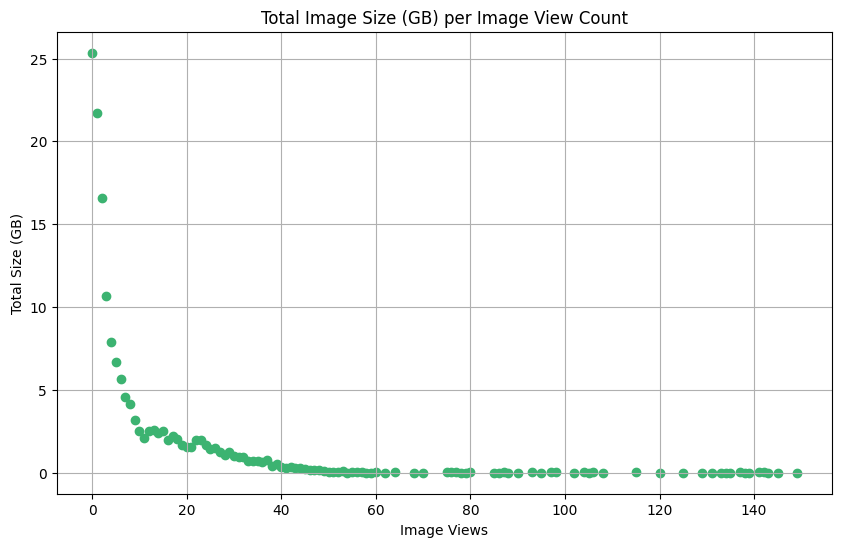

In [13]:
import matplotlib.pyplot as plt

# Aggregate total size per imageViews
size_per_views = df.groupby("imageViews")["size_mb"].sum().reset_index()
size_per_views["size_gb"] = size_per_views["size_mb"] / 1024

plt.figure(figsize=(10,6))
plt.scatter(size_per_views["imageViews"], size_per_views["size_gb"], color='mediumseagreen')
plt.xlabel("Image Views")
plt.ylabel("Total Size (GB)")
plt.title("Total Image Size (GB) per Image View Count")
plt.grid(True)
plt.show()

In [14]:
total_size_gb = images_df['size_mb'].sum() / 1024
print(f"Total size: {total_size_gb:.2f} GB")

Total size: 211.26 GB


In [15]:
# Filenames with at least one NaN
nan_files = df[df['latitude'].isna() & df['longitude'].isna()]['filename'].unique()

# Filenames with at least one not-NaN
not_nan_files = df[~(df['latitude'].isna() & df['longitude'].isna())]['filename'].unique()

print("Distinct filenames without latitude & longitude:", len(nan_files))
print("Distinct filenames WITH latitude & longitude:", len(not_nan_files))

Distinct filenames without latitude & longitude: 6736
Distinct filenames WITH latitude & longitude: 5810


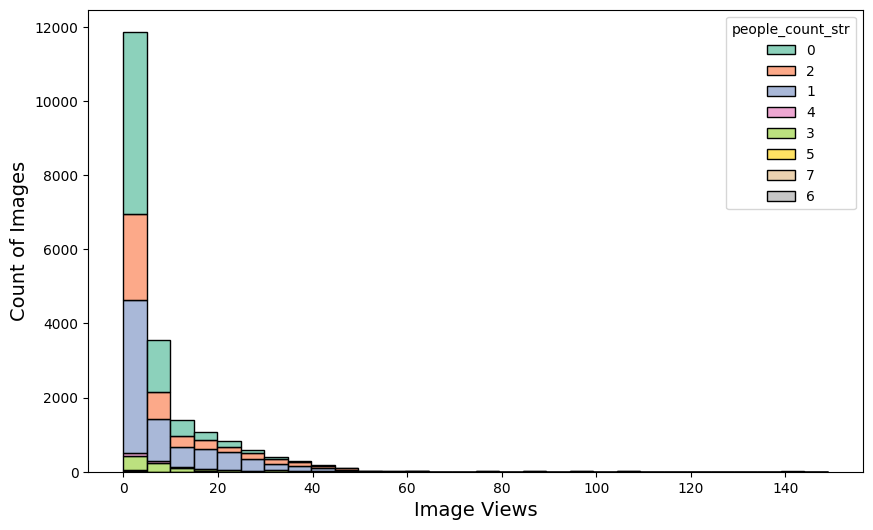

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Count number of people
df['people_count'] = df['people'].apply(len)

# Convert people_count to string for proper categorical hue
df['people_count_str'] = df['people_count'].astype(str)

# Set a vibrant color palette
palette = sns.color_palette("Set2", n_colors=df['people_count_str'].nunique())

# Simple histogram of imageViews for each people_count
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x='imageViews',
    hue='people_count_str',
    multiple='stack',
    bins=30,
    palette=palette,
    legend=True  # explicitly ensure Seaborn creates a legend
)

plt.xlabel('Image Views', fontsize=14)
plt.ylabel('Count of Images', fontsize=14)
plt.show()


In [17]:
import pandas as pd

# Filter for imageViews 0 through 20
filtered_df = df[df['imageViews'].isin(range(21))]  # 0 to 20 inclusive

# Count distinct URLs for each imageViews value
counts = filtered_df.groupby('imageViews')['url'].nunique()

# Print counts for all 0-20
for i in range(21):
    print(f"imageViews = {i}: {counts.get(i, 0)} distinct URLs")


imageViews = 0: 3510 distinct URLs
imageViews = 1: 2907 distinct URLs
imageViews = 2: 2469 distinct URLs
imageViews = 3: 1680 distinct URLs
imageViews = 4: 1300 distinct URLs
imageViews = 5: 1071 distinct URLs
imageViews = 6: 827 distinct URLs
imageViews = 7: 667 distinct URLs
imageViews = 8: 554 distinct URLs
imageViews = 9: 429 distinct URLs
imageViews = 10: 337 distinct URLs
imageViews = 11: 262 distinct URLs
imageViews = 12: 281 distinct URLs
imageViews = 13: 270 distinct URLs
imageViews = 14: 246 distinct URLs
imageViews = 15: 254 distinct URLs
imageViews = 16: 211 distinct URLs
imageViews = 17: 225 distinct URLs
imageViews = 18: 201 distinct URLs
imageViews = 19: 167 distinct URLs
imageViews = 20: 146 distinct URLs


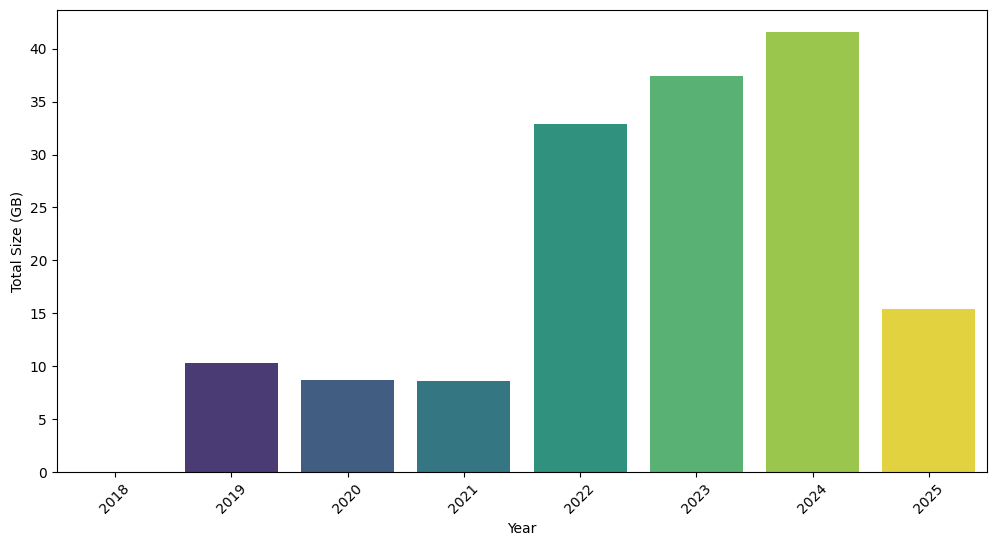

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
# Convert size from MB to GB
df['size_gb'] = df['size_mb'] / 1024

# Convert Unix epoch to datetime and extract the year
df['year'] = pd.to_datetime(df['photoTakenTime'], unit='s').dt.year

# Group by year and sum sizes
df_yearly = df.groupby('year')['size_gb'].sum().reset_index().sort_values(by='year')

plt.figure(figsize=(12,6))
sns.barplot(
    data=df_yearly,
    x='year',
    y='size_gb',
    hue='year',       # Assign x to hue
    palette='viridis',
    dodge=False,      # Needed for single bars per category
    legend=False       # Disable the legend
)
plt.xlabel('Year')
plt.ylabel('Total Size (GB)')
plt.xticks(rotation=45)
plt.show()


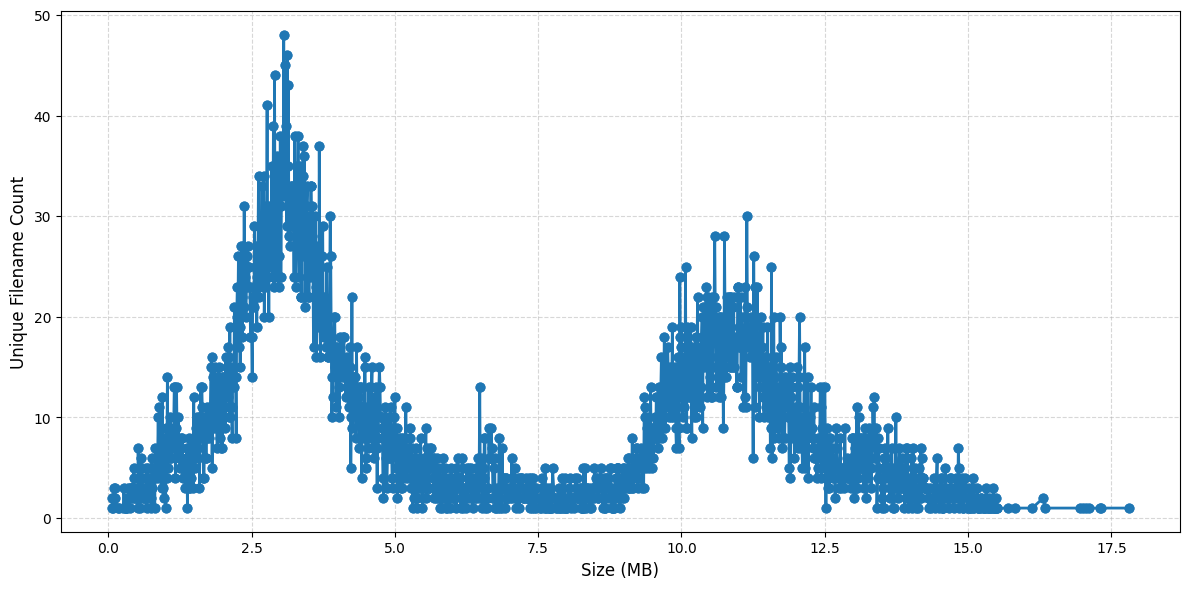

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: assume your dataframe looks like this:
# df.columns = ["filename", "size_mb"]

# 1. Group by size and count unique filenames
counts = (
    df.groupby("size_mb")["filename"]
      .nunique()
      .reset_index(name="unique_filename_count")
)

# 2. Plot distribution
plt.figure(figsize=(12, 6))

plt.plot(
    counts["size_mb"],
    counts["unique_filename_count"],
    marker="o",
    linewidth=2,
)

plt.scatter(
    counts["size_mb"],
    counts["unique_filename_count"],
    s=40
)

plt.xlabel("Size (MB)", fontsize=12)
plt.ylabel("Unique Filename Count", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [20]:
# total unique filenames
total_unique = df['filename'].nunique()

# unique filenames with imageViews >= 1
unique_with_views = df.loc[df['imageViews'] >= 35, 'filename'].nunique()

# percentage
percentage = (unique_with_views / total_unique) * 100

print("Total unique filenames:", total_unique)
print("Unique filenames with imageViews >= 35:", unique_with_views)
print("Percentage:", percentage)


Total unique filenames: 12546
Unique filenames with imageViews >= 35: 669
Percentage: 5.332376853180296


In [21]:
total_storage_gb = df.loc[df["imageViews"] >= 35, "size_mb"].sum() / 1024
total_storage_gb

np.float64(6.48806640625)